In [1]:
import pennylane as qml
import jax.numpy as jnp
import jax
import numpy as np
import matplotlib.pyplot as plt

jax.config.update("jax_enable_x64", True)

In this notebook, we illustrate the effect of a single qubit drive in the Bloch sphere. The drive is given by 

$$ H = - \omega_q /2 Z_q + \Omega(t) \sin(\nu t + \phi) Y_q $$

with the qubit freuqency $\omega$, drive frequency $\nu$, phase $\phi$ and amplitude $\Omega(t)$. The qubit naturally precesses around the Z-axis at its frequency. Driving on resonance $\omega = \nu$ leads to an additional Y-rotation at a angular velocity given by the amplitude. The effective rotation axis of the logical operation is set by the phase $\phi$, which can be seen in the following notebook. Alternatively, one can transform the Hamiltonian to the qubit frame and see that in the RWA one obtains (see eq. (92) in [arXiv:1904.06560](https://arxiv.org/pdf/1904.06560v5.pdf))

$$ \tilde{H} = - \Omega(t)/2 (\cos(\phi) X_q + \sin(\phi) Y_q). $$

In [2]:
qubit_freq = jnp.array([5.]) # in GHz
wires = [0]

T_single = 1. # in ns

H = qml.pulse.transmon_interaction(qubit_freq, [], [], wires)
H+= qml.pulse.transmon_drive(qml.pulse.constant, qml.pulse.constant, qubit_freq, wires)

device = qml.device("default.qubit.jax", wires=len(wires))

@qml.qnode(device, interface="jax")
def evolve(params, t):
    qml.evolve(H)(params, t, return_intermediate=True, atol=1e-15)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)), qml.expval(qml.PauliZ(0))]

amplitude = 0.5 # in GHz
times = jnp.linspace(0, T_single, 500)

params = jnp.array([amplitude, 0.])
coords0 = evolve(params, times)
coords0 = np.array(coords0)

params = jnp.array([amplitude, np.pi/2])
coords1 = evolve(params, times)
coords1 = np.array(coords1)

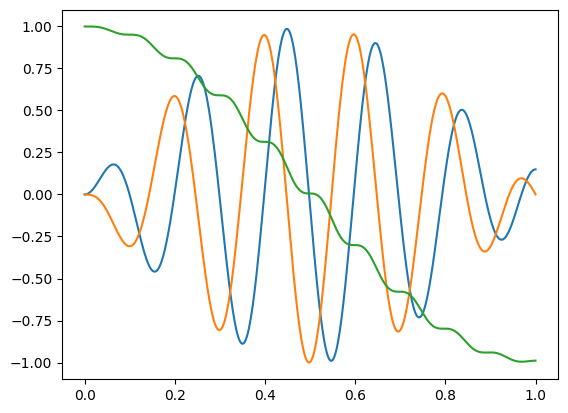

In [3]:
plt.plot(times, coords0.T)
plt.show()

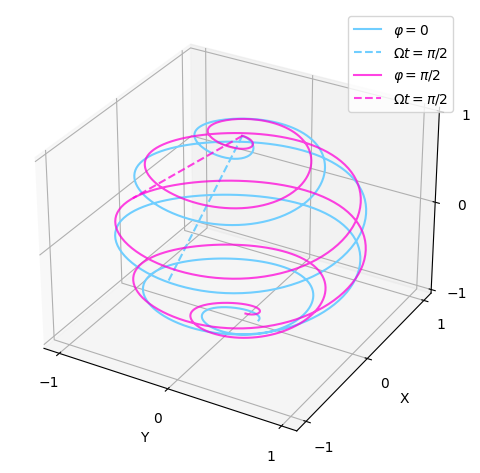

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
color = ['#70CEFF', '#D7A2F6', '#ff00d9bc', '#FF87EB', '#FFE096', '#FDC9DE', '#E1EBA8', '#C6FDD9']

# Plot the trajectory
ax.plot(*coords0, "-", label="$\\varphi=0$", color=color[0])
# pi/2 pulse by setting 2 pi amplitude  t = pi/2 => t = 1/(4 amplitude)
res = evolve([amplitude, 0.], (0., 1/amplitude/4))
res = np.array(res)
ax.plot(*res, "--", label="$\\Omega t = \\pi/2$", color=color[0])



ax.plot(*coords1, "-", label="$\\varphi=\\pi/2$", color=color[2])
res = evolve([amplitude, jnp.pi/2], (0., 1/amplitude/4))
res = np.array(res)
ax.plot(*res, "--", label="$\\Omega t = \\pi/2$", color=color[2])

# Set labels for each axis
ax.set_xlabel('Y')
ax.set_ylabel('X')
ax.set_zlabel('Z')
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])
ax.set_zticks([-1, 0, 1])

ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig("plots/1qubit.svg", dpi=500, bbox_inches='tight')


Another way to look at this is by varying the amplitude:

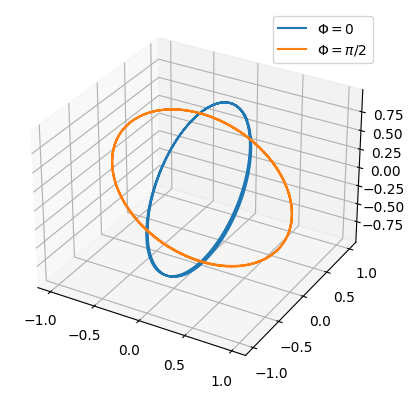

In [5]:
X, Y, Z = qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)

omega = 2 * jnp.pi * 5.
H = -omega/2 * Z

def amp(p, t):
    return p[0] * jnp.sin(omega*t + p[1])
H += amp * Y

@jax.jit
@qml.qnode(qml.device("default.qubit", wires=1), interface="jax")
def trajectory(Omega0, phi):
    qml.evolve(H)([[Omega0, phi]], 20.)
    return [qml.expval(op) for op in [X, Y, Z]]

phi = 0
Omegas = jnp.linspace(0., 1., 10000)
res0 = jax.vmap(trajectory, [0, None])(Omegas, phi)
res1 = jax.vmap(trajectory, [0, None])(Omegas, jnp.pi/2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(*res0, "-", label="$\\Phi=0$")
ax.plot(*res1, "-", label="$\\Phi=\\pi/2$")
ax.legend()